In [120]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [121]:
transit_df = pd.read_csv("transit_stops_datasd.csv")
transit_df = transit_df[transit_df['stop_agncy'] == 'MTS']
transit_df = transit_df.drop(['stop_uid', 'stop_lat', 'stop_lon', 'stop_agncy', 'stop_code', 'stop_id', 'wheelchair', 'intersec', 'stop_place', 'parent_sta'], axis=1)
transit_df.head()

,objectid,stop_name,lat,lng
0,1,11th Ave & Broadway,32.716263,-117.154637
1,2,12th & Imperial Station,32.705997,-117.153366
2,3,12th & Imperial Station Bayside,32.705224,-117.154306
3,4,12th & Imperial Transit Center,32.705680,-117.152863
4,5,24th Street Station,32.661849,-117.108005


An important discussion in this case is working on transit density analysis. This is useful for our research question as it helps us understand the transit density and composition of transit density for San Diego neighborhoods. For this, we will first start by examining the 2025 updated version.

In [122]:
transit_gdf = gpd.GeoDataFrame(transit_df, geometry=gpd.points_from_xy(y=transit_df.lat, x=transit_df.lng), crs="EPSG:4326")
transit_gdf.head(5)

,objectid,stop_name,lat,lng,geometry
0,1,11th Ave & Broadway,32.716263,-117.154637,POINT (-117.15464 32.71626)
1,2,12th & Imperial Station,32.705997,-117.153366,POINT (-117.15337 32.706)
2,3,12th & Imperial Station Bayside,32.705224,-117.154306,POINT (-117.15431 32.70522)
3,4,12th & Imperial Transit Center,32.705680,-117.152863,POINT (-117.15286 32.70568)
4,5,24th Street Station,32.661849,-117.108005,POINT (-117.10801 32.66185)


For geocoding the neighborhoods of San Diego, we use the map used by the San Diego Police Department which assigns beats to neighborhoods. This encoding is saved to neighborhoods. We have plotted it using the shapefile in the Github.

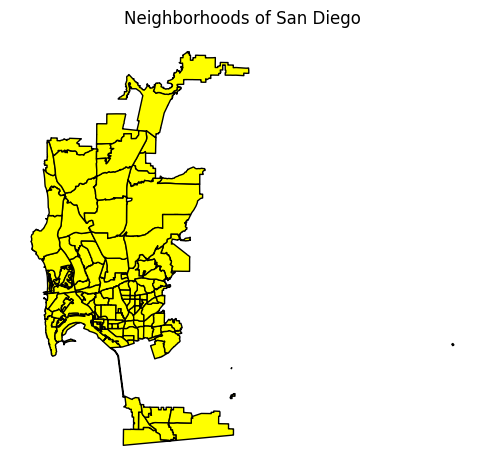

In [123]:
neighborhoods = gpd.read_file("SDPD_Beats_shapefile/SDPD_Beats.shp")
neighborhoods.plot(figsize=(6, 6), color="yellow", edgecolor="black")
plt.title("Neighborhoods of San Diego", fontsize=12)
plt.axis("off")
plt.show()

However, some parts of the San Diego city are military zones, agricultural land, or natural preserves. These are areas which often cannot have transit stations built within and often around. These serve to obfuscate our results as they do not show the effect of transit on housing, but rather the effect of various confounding factors like the prevalence of agricultural land or military regulation. Thus, we will be removing these regions from our neighborhoods and analysis by using a Zoning Map of San Diego. The Zoning Codes AR-1-1 and AG-1-1 correspond to these artificially restricted zones. We have kept AR-1-2 on the grounds that the minimum area of housing is 1 acre which allows for greater residential density.

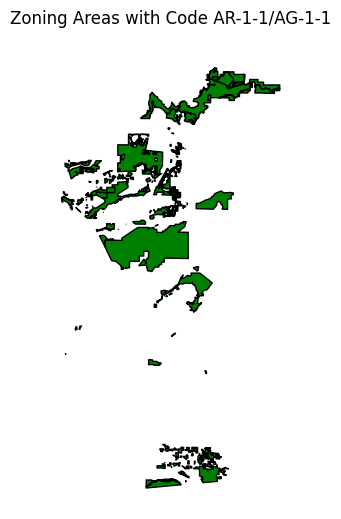

In [124]:
zones = gpd.read_file("Zoning_Base_SD_shapefile/Zoning_Base_SD.shp")
uncounted_zones = zones[zones["ZONE_NAME"].isin(["AR-1-1", "AG-1-1", "AR-1-2"])]
uncounted_zones.plot(figsize=(6, 6), color="green", edgecolor="black")
plt.title("Zoning Areas with Code AR-1-1/AG-1-1", fontsize=12)
plt.axis("off")
plt.show()

In [125]:
#Ensure and define the coordinate system being used for the geopandas dataframes
transit_gdf = transit_gdf.to_crs(epsg=26911)
neighborhoods = neighborhoods.to_crs(epsg=26911)
uncounted_zones = uncounted_zones.to_crs(epsg=26911)


Now we will remove these specific Zoned Areas from the Neighborhoods of San Diego.

/var/folders/zf/1s145dnx53b_5zr2zxzzh0bc0000gn/T/ipykernel_43254/2818321882.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 336 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')


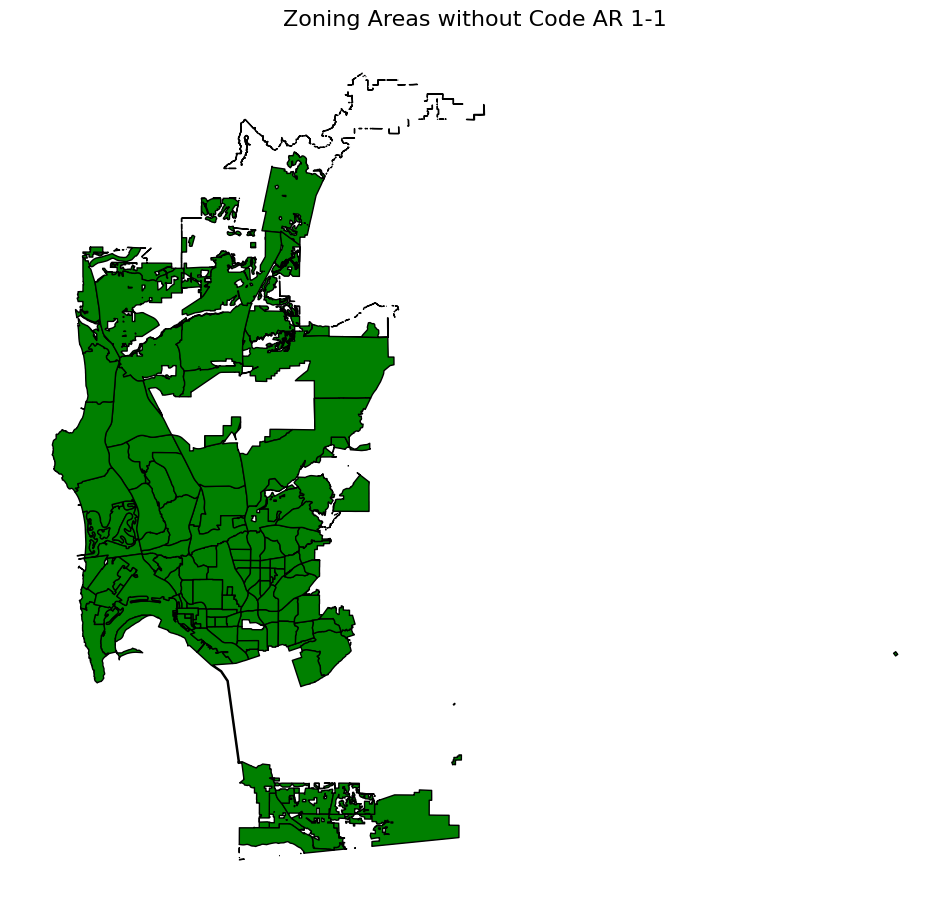

In [127]:
neighborhoods_cleaned = gpd.overlay(neighborhoods, uncounted_zones, how='difference')
neighborhoods_cleaned.plot(figsize=(12, 12), color="green", edgecolor="black")
plt.title("Zoning Areas without Code AR 1-1", fontsize=16)
plt.axis("off")
plt.show()

Now, there are specific ways to get exact walking time limits to bus stops for a particular neighborhood. However, these practices are power-consuming, inefficient and do not serve the purpose of illuminating transit density any greater than analysis through centroid-based granularity. Thus, it is a caveat of this analysis that the buffer is based more on distance from neighborhood centroids which is in part to work with the granularity of the ZHVI dataset. Thus, we look at transit stops within a walking distance of 10 minutes from the neighborhood.

In [131]:
neighborhoods_cleaned["buffer_850m"] = neighborhoods_cleaned.geometry.centroid.buffer(850)
buffered = gpd.GeoDataFrame(neighborhoods_cleaned, geometry="buffer_850m")
joined = gpd.sjoin(transit_gdf, buffered, predicate="within", how="inner")
stop_counts = joined.groupby("NAME").size().reset_index(name="stop_count_850m")
neighborhoods_cleaned = neighborhoods_cleaned.merge(stop_counts, on="NAME", how="left")
neighborhoods_cleaned["stop_count_850m"] = neighborhoods_cleaned["stop_count_850m"].fillna(0)

In [136]:
neighborhoods_cleaned.head()

,NAME,Shape_Leng,Shape_Area,geometry,buffer_850m,stop_count_850m
0,NORTH CITY,78873.923071,1.331477e+08,"MULTIPOLYGON (((477797.712 3649302.809, 477890...","POLYGON ((480870.201 3648316.467, 480866.108 3...",0.0
1,SAN DIEGO,242010.100987,1.965744e+08,"MULTIPOLYGON (((488757.687 3607730.058, 488778...","POLYGON ((483150.431 3618496.939, 483146.338 3...",1.0
2,None,44637.828529,2.094335e+07,"MULTIPOLYGON (((478884.339 3618340.826, 478887...","POLYGON ((480620.488 3618226.76, 480616.395 36...",0.0
3,NESTOR,35035.587936,4.154836e+07,"MULTIPOLYGON (((491839.499 3605063.938, 491841...","POLYGON ((493054.328 3603458.691, 493050.235 3...",14.0
4,BIRDLAND,25427.282928,2.168501e+07,"POLYGON ((485817.337 3629845.674, 485825.659 3...","POLYGON ((486357.153 3628235.71, 486353.06 362...",15.0


Let us take a look at neighborhoods that have 0 stops within 850 meters of their centroids.

In [137]:
neighborhoods_cleaned[neighborhoods_cleaned['stop_count_850m'] == 0]

,NAME,Shape_Leng,Shape_Area,geometry,buffer_850m,stop_count_850m
0,NORTH CITY,78873.923071,1.331477e+08,"MULTIPOLYGON (((477797.712 3649302.809, 477890...","POLYGON ((480870.201 3648316.467, 480866.108 3...",0.0
2,None,44637.828529,2.094335e+07,"MULTIPOLYGON (((478884.339 3618340.826, 478887...","POLYGON ((480620.488 3618226.76, 480616.395 36...",0.0
23,MIRAMAR RANCH NORTH,52761.199605,8.959434e+07,"MULTIPOLYGON (((490599.162 3644781.711, 490754...","POLYGON ((492040.198 3643502.178, 492036.105 3...",0.0
40,RANCHO ENCANTADA,64198.764979,1.177613e+08,"MULTIPOLYGON (((500694.903 3644914.398, 500694...","POLYGON ((498176.181 3642858.371, 498172.088 3...",0.0
84,BROADWAY HEIGHTS,10779.359462,2.439079e+06,"POLYGON ((495334.047 3621618.95, 495333.947 36...","POLYGON ((495784.482 3621456.616, 495780.389 3...",0.0
88,TORREY PRESERVE,53210.099451,6.637073e+07,"MULTIPOLYGON (((475603.047 3644510.984, 475603...","POLYGON ((477948.463 3642163.639, 477944.371 3...",0.0
107,OCEAN CREST,40379.279989,8.150667e+07,"MULTIPOLYGON (((499263.167 3605102.175, 499287...","POLYGON ((498827.479 3604486.93, 498823.386 36...",0.0
108,LAKE MURRAY,86197.318228,1.679345e+08,"MULTIPOLYGON (((499073.645 3630842.168, 499085...","POLYGON ((498780.991 3630425.863, 498776.898 3...",0.0
117,DEL MAR HEIGHTS,44469.279211,6.064530e+07,"MULTIPOLYGON (((477105.941 3646594.713, 477119...","POLYGON ((477431.802 3645841.159, 477427.709 3...",0.0
119,CARMEL VALLEY,92565.902459,3.960763e+08,"MULTIPOLYGON (((484116.912 3645990.945, 483528...","POLYGON ((480871.036 3645028.91, 480866.943 36...",0.0


Finally, let us make a map of the San Diego region which shows us transit density (number of stops within an 850 meter radius from the centroid).

<Axes: >

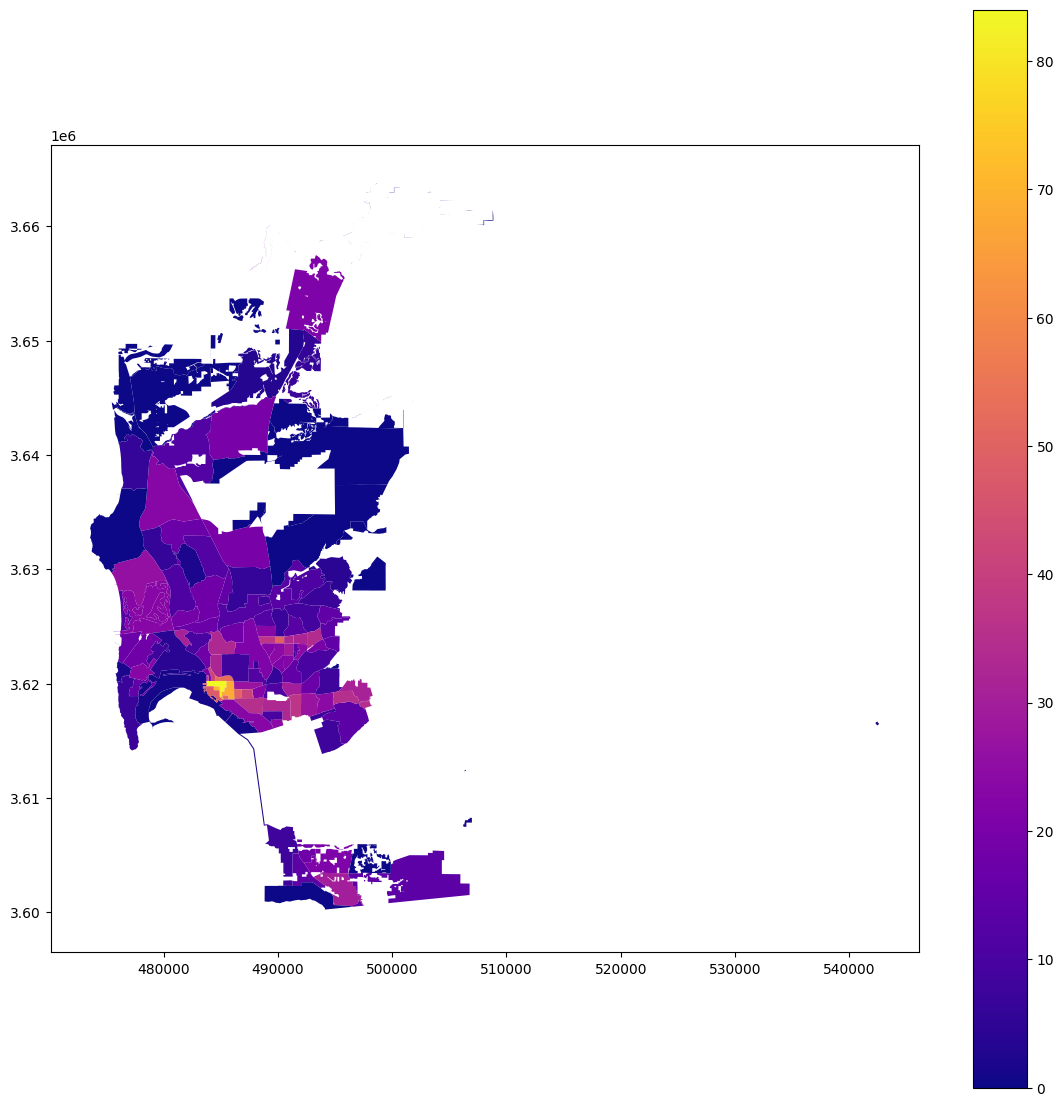

In [133]:
neighborhoods_cleaned.plot(column="stop_count_850m", cmap="plasma", legend=True, figsize=(14,14))